# Compressing exisiting data

In [1]:
using PythonCall: PythonCall
using PythonPlot: pyplot as plt, Figure

# Displays the matplotlib figure object `fig` and avoids duplicate plots.
_display(fig::Figure) = isinteractive() ? (fig; plt.show(); nothing) : Base.display(fig)
_display(fig::PythonCall.Py) = _display(Figure(fig))

_display (generic function with 2 methods)

## TCI

Let us demonstrate how to compress exisiting data by TCI.
First, we create a test dataset on a 3D grid.

In [2]:
# Replace this line with the dataset to be tested for compressibility.
grid = range(-pi, pi; length=200)
dataset = [cos(x) + cos(y) + cos(z) for x in grid, y in grid, z in grid]
size(dataset)

(200, 200, 200)

We now construct a TCI.

In [3]:
import TensorCrossInterpolation as TCI

# Construct TCI
tolerance = 1e-5
tt, ranks, errors = TCI.crossinterpolate2(
    Float64, i -> dataset[i...], collect(size(dataset)), tolerance=tolerance)

# Check error
ttdataset = [tt([i, j, k]) for i in axes(grid, 1), j in axes(grid, 1), k in axes(grid, 1)]
errors = abs.(ttdataset .- dataset)
println(
    "TCI of the dataset with tolerance $tolerance has link dimensions $(TCI.linkdims(tt)), "
    * "for a max error of $(maximum(errors))."
)

TCI of the dataset with tolerance 1.0e-5 has link dimensions [2, 2], for a max error of 1.7763568394002505e-15.


Let us plot the original data and the TCI error on a 2D cut.

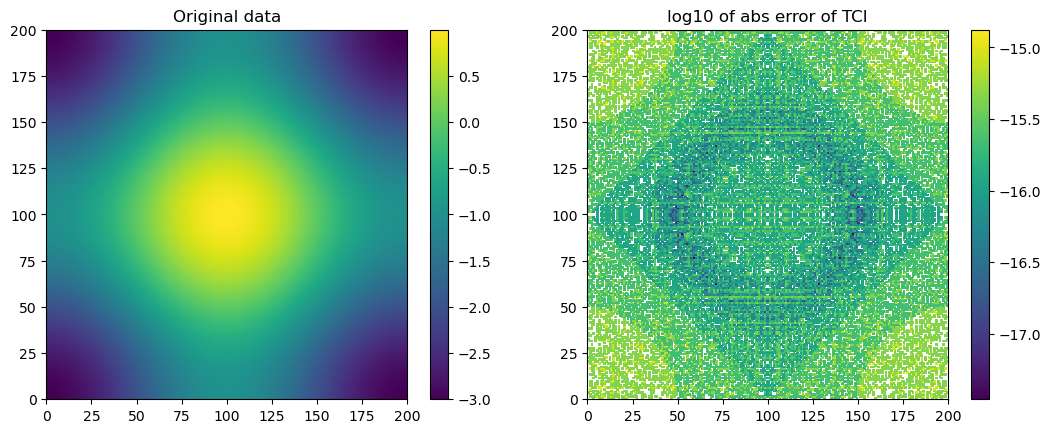

In [4]:
fig, axs = plt.subplots(1, 2; figsize=(12.8, 4.8))

# Original data
c = axs[0].pcolor(dataset[:, :, 1])
fig.colorbar(c, ax=axs[0])
axs[0].set_title("Original data")

# TCI error
c = axs[1].pcolor(log10.(abs.(errors[:, :, 1])))
fig.colorbar(c, ax=axs[1])
axs[1].set_title("log10 of abs error of TCI")

_display(fig)

## QTCI

We now demonstrate how to compress existing data by QTCI.

In [5]:
# Number of bits
R = 8

# Replace with your dataset
grid = range(-pi, pi; length=2^R+1)[1:end-1] # exclude the end point
dataset = [cos(x) + cos(y) + cos(z) for x in grid, y in grid, z in grid]
size(dataset)

(256, 256, 256)

### QuanticsTCI.jl
Let us first use `quanticscrossinterpolate` function in `QuanticsTCI.jl`.

In [6]:
using QuanticsTCI
import TensorCrossInterpolation as TCI

# Perform QTCI
tolerance = 1e-5
qtt, ranks, errors = quanticscrossinterpolate(
    dataset, tolerance=tolerance, unfoldingscheme=:fused)

(QuanticsTCI.QuanticsTensorCI2{Float64}(TensorCrossInterpolation.TensorCI2{Float64} with rank 6, QuanticsGrids.InherentDiscreteGrid{3}(8, (1, 1, 1), 2, :fused, (1, 1, 1)), TensorCrossInterpolation.CachedFunction{Float64, UInt128} with 19679 entries), [6, 6, 6], [6.784527796156447e-16, 6.625088666912402e-16, 5.152723411366169e-16])

Below, we compute the error for the whole tensor, which may be too expensive for a large $\mathcal{R}$.

In [7]:
# Check error
qttdataset = [qtt([i, j, k]) for i in axes(grid, 1), j in axes(grid, 1), k in axes(grid, 1)]
qtterrors = abs.(qttdataset .- dataset)
println(
    "Quantics TCI compression of the dataset with tolerance $tolerance has " *
    "link dimensions $(TCI.linkdims(qtt.tci)), for a max error of $(maximum(qtterrors))."
)

Quantics TCI compression of the dataset with tolerance 1.0e-5 has link dimensions [3, 6, 6, 6, 6, 6, 4], for a max error of 5.773159728050814e-15.


Again, let us plot the original data and the TCI error on a 2D cut.

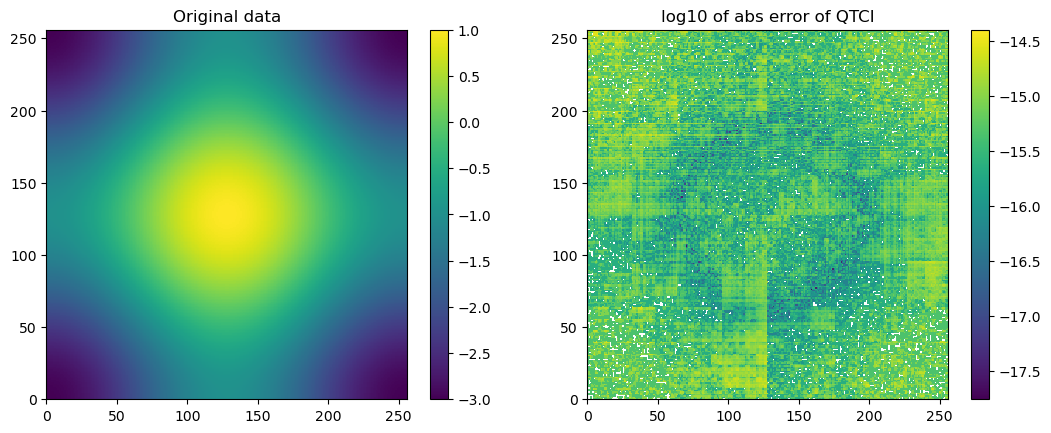

In [8]:
using PythonPlot: pyplot as plt, gcf

fig, axs = plt.subplots(1, 2; figsize=(12.8, 4.8))

# Original data
c = axs[0].pcolor(qttdataset[:, :, 1])
fig.colorbar(c, ax=axs[0])
axs[0].set_title("Original data")

# TCI error
c = axs[1].pcolor(log10.(abs.(qtterrors[:, :, 1])))
fig.colorbar(c, ax=axs[1])
axs[1].set_title("log10 of abs error of QTCI")

_display(fig)

### QuanticsGrids.jl + TensorCrossInterpolation.jl

`QuanticsTCI.jl` is user-friendly, yet utilizing `QuanticsGrids.jl` directly provides greater flexibility.

In [9]:
import QuanticsGrids as QG


function create_qgrid(R, qttdataset)
    # 3D quantics grid with R bits and the fused reprensentation (default)
    qgrid = QG.InherentDiscreteGrid{3}(R)

    # Function that returns the value of the dataset at the given quantics index
    qf(qindex) = qttdataset[QG.quantics_to_grididx(qgrid, qindex)...]

    return qgrid, qf
end

qgrid, qf = create_qgrid(R, qttdataset)

# Data at the quantics index [1, 1, ..., 1] = the index [1, 1, 1].
qf(fill(1, R)) == qttdataset[1, 1, 1]

true

The `create_qgrid` function generates a 3D quantics grid and a closure (`qf`) for dataset access based on quantics indices, given a grid resolution (`R`) and a dataset (`qttdataset`).
This design reduces reliance on global variables, leading to faster function evalulations.

The effectiveness of TCI significantly depends on selecting appropriate initial pivots.
Optimal initial pivots are locations where the function intended for interpolation exhibits large absolute values.

In [10]:
# Local dimensions
localdims = fill(8, R)

# Generate initial pivots by maximainzing the aboslute value of the function from random points.
# This is a heuristic to find good initial pivots.
# The optimization is performed by single-sites updates.
ninitialpivots = 10
initialpivots = [TCI.optfirstpivot(qf, localdims, [rand(1:d) for d in localdims]) for _ in 1:ninitialpivots]

for p in initialpivots
    println("Initial pivot: $p $(qf(p))")
end

Initial pivot: [3, 3, 3, 3, 3, 3, 3, 3] -2.999698818696205
Initial pivot: [1, 1, 1, 1, 1, 1, 1, 1] -3.0
Initial pivot: [2, 2, 2, 2, 2, 2, 2, 2] -2.999698818696202
Initial pivot: [1, 1, 1, 1, 1, 1, 1, 1] -3.0
Initial pivot: [4, 5, 5, 5, 5, 5, 5, 5] 2.9996988186962046
Initial pivot: [2, 7, 7, 7, 7, 7, 7, 7] 2.999397637392408
Initial pivot: [1, 1, 1, 1, 1, 1, 1, 1] -3.0
Initial pivot: [3, 6, 6, 6, 6, 6, 6, 6] 2.9993976373924074
Initial pivot: [4, 5, 5, 5, 5, 5, 5, 5] 2.9996988186962046
Initial pivot: [8, 8, 8, 8, 8, 8, 8, 8] -2.999096456088613


In [11]:
# Perform (Q)TCI
tolerance = 1e-5
qtt, ranks, errors = TCI.crossinterpolate2(Float64, qf, localdims, initialpivots; tolerance=tolerance)

(TensorCrossInterpolation.TensorCI2{Float64} with rank 6, [6, 6, 6], [1.3205367710218091e-15, 1.3112899981877856e-15, 1.3112899981877856e-15])

In [12]:
# Test error
qtt(initialpivots[1]) ≈ qf(initialpivots[1])

true